# Collecting data
Getting bug or enhancement issues in my favorite repo using github API 

In [1]:
from github import Github
from github import Auth

auth = Auth.Token("")

issues = []
bugs = []
enhancements = []

g = Github(auth=auth)
repo = g.get_repo("hyprwm/hyprland")
bug_label = repo.get_label("bug")
enhancement_label = repo.get_label("enhancement")

for i in repo.get_issues(labels=[bug_label]):
    bugs.append((i.title, i.body))
    print(i)

for i in repo.get_issues(state="closed", labels=[bug_label]):
    bugs.append((i.title, i.body))
    print(i)

for i in repo.get_issues(labels=[enhancement_label]):
    enhancements.append((i.title, i.body))
    print(i)

for i in repo.get_issues(state="closed", labels=[enhancement_label]):
    enhancements.append((i.title, i.body))
    print(i)

print(f"bugs found: {len(bugs)}, enhancements found: {len(enhancements)}")

Issue(title="Dmabuf capture region has incorrect size when using weird scaling settings", number=4991)
Issue(title="Program becomes blurry when moving from a lower resolution screen to higher resolution screen using keyboard shortcut", number=4987)
Issue(title="hyprland 0.36.0 fails to compile musl", number=4985)
Issue(title="Steam Friends List sometimes spawns in the smallest possible size", number=4976)
Issue(title="GTK4 Popup Does Not Release Keyboard On Close", number=4973)
Issue(title="Layershells cannot steal focus from a window that has captured the mouse", number=4968)
Issue(title="Unexpected togglefloating dispatcher behavior", number=4967)
Issue(title="initialClass/initialclass capitalization mismatch between documentation and `hyprctl clients` output versus hyprland.conf parsing", number=4965)
Issue(title="Lost keyboard input after continous switch movefocus", number=4955)
Issue(title="Using focuswindow with follow_mouse=2 will warp cusor but not cursor focus.", number=4949)

In [2]:
bugs_processed = []
for issue in bugs:
    body = issue[1]
    if body is None: 
        continue
    body = body[body.find("Description") + len("Description") : body.find("Crash reports")]
    bugs_processed.append((issue[0], body))

bugs_processed

[('Dmabuf capture region has incorrect size when using weird scaling settings',
  '\r\n\r\nReported initially at https://github.com/russelltg/wl-screenrec/issues/64, but reproduced by me as well\r\n\r\nWhen I set scaling to 2.4, on both 4k and 1920x1200 displays, when I ask for dmabuf screen capture, the DMABUF region is two pixels too small in both directions. This is visible in the vvv.txt attached to https://github.com/russelltg/wl-screenrec/issues/41#issuecomment-1973591012:\r\n\r\n```\r\nzwlr-screencopy-frame event: ObjectId(zwlr_screencopy_frame_v1@11, 56) Buffer { format: Value(Xbgr8888), width: 3838, height: 2158, stride: 15352 }\r\nzwlr-screencopy-frame event: ObjectId(zwlr_screencopy_frame_v1@11, 56) LinuxDmabuf { format: 875713112, width: 3838, height: 2158 }\r\n```\r\n\r\nThis then later causes issue in my application because I crop it to regions calculated from scaling, so it causes error when the copped region is larger than the full screen!\r\n\r\nWorks in sway.\r\n\r\n#

## Transforming to DataFrame

In [56]:
import pandas as pd

df_bugs = pd.DataFrame(data=bugs_processed, columns=['title', 'body'])
df_bugs['type'] = 0 

df_enhancements = pd.DataFrame(enhancements, columns=['title', 'body'])
df_enhancements['type'] = 1

# take only part of 'bugs' in order to have 50/50 types in train dataset
df = pd.concat([df_bugs.sample(frac=0.3), df_enhancements])
df.to_csv("issues.csv")
df = df.assign(text=df['title'] + " " + df['body'])
df

,title,body,type,text
1343,Black screen on launch,"\n\nThe screen is completely black, I can see ...",0,Black screen on launch \n\nThe screen is compl...
727,Moving window to special workspace doesn't all...,"\n\nWhen I upgraded Hyprland, I was noticing t...",0,Moving window to special workspace doesn't all...
2497,changing workspace dont change focus,reproduce**\r\nopen terminal in workspace 1\r...,0,changing workspace dont change focus reproduc...
325,Segfault after connecting monitor before resum...,\r\n\r\nI have the [ThinkPad Basic Dock (40AG0...,0,Segfault after connecting monitor before resum...
2501,ibus doesn't work properly under hyprland,d ibus and ibus-libpinyin for input Chinese an...,0,ibus doesn't work properly under hyprland d ib...
...,...,...,...,...
858,Tabbed containers,**Describe in detail your idea.**\r\nMy primar...,1,Tabbed containers **Describe in detail your id...
859,Mouse constraints/locking isn't implemented.,"Especially games, which use the cursor for loo...",1,Mouse constraints/locking isn't implemented. E...
860,Forgotten cd in Wiki/Installation,**Describe in detail your idea.**\r\nHi! I was...,1,Forgotten cd in Wiki/Installation **Describe i...
861,Nvidia support?,I couldn't find an answer to this in the wiki....,1,Nvidia support? I couldn't find an answer to t...


In [57]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

stemmer = PorterStemmer()
eng_stopwords = stopwords.words('english')
eng_stopwords = set(eng_stopwords)

df = df.dropna()
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ', text, flags=re.MULTILINE)
    is_allowed_char = lambda c: c.isalpha() or c.isspace()
    text = ''.join(list(filter(is_allowed_char, text)))

    is_not_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_not_stopword, text.split())))
    text = ' '.join(list(filter(lambda x: len(x) < 15, text.split())))
    text = ' '.join(list(map(stemmer.stem, text.split())))

    return text

df = df.assign(text=[preprocess_text(t) for t in df.text])
df

[nltk_data] Downloading package stopwords to /home/vmedv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,body,type,text
1343,Black screen on launch,"\n\nThe screen is completely black, I can see ...",0,black screen launch screen complet black see p...
727,Moving window to special workspace doesn't all...,"\n\nWhen I upgraded Hyprland, I was noticing t...",0,move window special workspac doesnt allow curs...
2497,changing workspace dont change focus,reproduce**\r\nopen terminal in workspace 1\r...,0,chang workspac dont chang focu reproduc open t...
325,Segfault after connecting monitor before resum...,\r\n\r\nI have the [ThinkPad Basic Dock (40AG0...,0,segfault connect monitor resum sleep thinkpad ...
2501,ibus doesn't work properly under hyprland,d ibus and ibus-libpinyin for input Chinese an...,0,ibu doesnt work properli hyprland ibu ibuslibp...
...,...,...,...,...
858,Tabbed containers,**Describe in detail your idea.**\r\nMy primar...,1,tab contain describ detail idea primari usecas...
859,Mouse constraints/locking isn't implemented.,"Especially games, which use the cursor for loo...",1,mous isnt implement especi game use cursor loo...
860,Forgotten cd in Wiki/Installation,**Describe in detail your idea.**\r\nHi! I was...,1,forgotten cd describ detail idea hi instal awe...
861,Nvidia support?,I couldn't find an answer to this in the wiki....,1,nvidia support couldnt find answer wiki plan d...


(array([  4.,  35., 261., 624., 524., 144.,  31.,  20.,   5.,   3.]),
 array([0.69314718, 1.46978887, 2.24643056, 3.02307225, 3.79971394,
        4.57635563, 5.35299732, 6.12963901, 6.9062807 , 7.68292239,
        8.45956408]),
 <BarContainer object of 10 artists>)

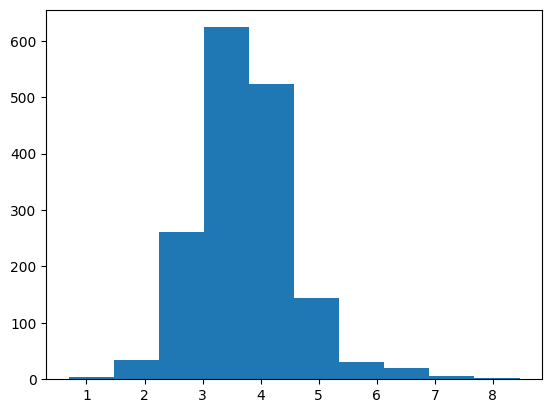

In [58]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist([np.log(len(text.split())) for text in df.text])

In [59]:
df = df[df.apply(lambda x: len(x.text.split()) < 120, axis=1)]
df

,title,body,type,text
1343,Black screen on launch,"\n\nThe screen is completely black, I can see ...",0,black screen launch screen complet black see p...
727,Moving window to special workspace doesn't all...,"\n\nWhen I upgraded Hyprland, I was noticing t...",0,move window special workspac doesnt allow curs...
2497,changing workspace dont change focus,reproduce**\r\nopen terminal in workspace 1\r...,0,chang workspac dont chang focu reproduc open t...
325,Segfault after connecting monitor before resum...,\r\n\r\nI have the [ThinkPad Basic Dock (40AG0...,0,segfault connect monitor resum sleep thinkpad ...
2501,ibus doesn't work properly under hyprland,d ibus and ibus-libpinyin for input Chinese an...,0,ibu doesnt work properli hyprland ibu ibuslibp...
...,...,...,...,...
858,Tabbed containers,**Describe in detail your idea.**\r\nMy primar...,1,tab contain describ detail idea primari usecas...
859,Mouse constraints/locking isn't implemented.,"Especially games, which use the cursor for loo...",1,mous isnt implement especi game use cursor loo...
860,Forgotten cd in Wiki/Installation,**Describe in detail your idea.**\r\nHi! I was...,1,forgotten cd describ detail idea hi instal awe...
861,Nvidia support?,I couldn't find an answer to this in the wiki....,1,nvidia support couldnt find answer wiki plan d...


In [60]:
texts = df.text.to_list() 
texts

['black screen launch screen complet black see pointer initi sinc pinephon touchscreen pointer normal tri launch termin physic keyboard noth happen shortcut exit work reproduc launch',
 'move window special workspac doesnt allow cursor interact regular window upgrad hyprland notic move window special workspac wouldnt allow use window regular workspac pleas fix realli break probabl mani other workflow reproduc make sure use version hyprland specifi move window special workspac tri interact window regular workspac case open brave open video special workspac tri open new brave tab cannot click new tab button anymor',
 'chang workspac dont chang focu reproduc open termin workspac open termin workspac switch back workspac focu stay termin workspac expect outcom focu switch termin workspac fix problem seem caus commit dedhttp simpl git revert fix',
 'segfault connect monitor resum sleep thinkpad basic dock agushttp thinkpad ps gen provid displayport passiv usbc andor proprietari connector ha

In [61]:
from typing import List
from collections import Counter
from itertools import chain

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [62]:
# texts = df.text.tolist()
vocab = build_vocab(texts)
print(len(vocab))
# слова разного регистра
vocab.most_common(30)


5377


[('window', 1807),
 ('workspac', 1102),
 ('hyprland', 986),
 ('use', 876),
 ('monitor', 788),
 ('would', 641),
 ('like', 518),
 ('work', 499),
 ('reproduc', 440),
 ('open', 417),
 ('set', 406),
 ('move', 396),
 ('fullscreen', 352),
 ('http', 343),
 ('hyprctl', 336),
 ('issu', 330),
 ('descript', 313),
 ('screen', 312),
 ('config', 311),
 ('make', 304),
 ('bind', 301),
 ('switch', 291),
 ('one', 288),
 ('crash', 278),
 ('chang', 273),
 ('mous', 273),
 ('option', 265),
 ('current', 262),
 ('tri', 255),
 ('float', 251)]

In [63]:
for word, freq in vocab.most_common(30):
    if word in vocab:  # чтобы код не сломался при повторном исполнении
        vocab.pop(word)

for word in sorted(vocab)[-30:-1]:
    if word in vocab:  # чтобы код не сломался при повторном исполнении
        vocab.pop(word)

print(sorted(vocab.keys()))

vocab

['aa', 'abcebcafacdebf', 'abi', 'abil', 'abl', 'abnorm', 'abnt', 'abort', 'aboutconfig', 'abovedp', 'absent', 'absmisc', 'absolut', 'abstract', 'abt', 'accel', 'acceler', 'accelprofil', 'accent', 'accept', 'access', 'accid', 'accident', 'accomplish', 'accord', 'accordingli', 'account', 'accumul', 'accuraci', 'accustom', 'acda', 'acfdecbabfbf', 'achiev', 'acknowledg', 'acommod', 'across', 'act', 'action', 'activ', 'activebord', 'activefocus', 'activelanguag', 'activeopac', 'activewindow', 'activewindowv', 'actli', 'actual', 'ad', 'adapt', 'add', 'addict', 'addit', 'addmast', 'addon', 'addremov', 'addreserv', 'address', 'addressa', 'addressxbff', 'ade', 'adher', 'adit', 'adjac', 'adjust', 'administr', 'adopt', 'adress', 'advanc', 'advantag', 'advertis', 'advic', 'advis', 'adwaita', 'aether', 'aexec', 'afaict', 'afaik', 'afb', 'afcaefebdedeef', 'affect', 'afterward', 'age', 'agent', 'aggrev', 'ago', 'agushttp', 'ai', 'ail', 'aim', 'aint', 'aka', 'akin', 'alacr', 'alacritti', 'alacrittyor'

Counter({'cursor': 245,
         'run': 241,
         'im': 237,
         'get': 234,
         'add': 234,
         'also': 219,
         'could': 217,
         'error': 215,
         'way': 213,
         'featur': 213,
         'focu': 211,
         'layout': 210,
         'file': 207,
         'x': 206,
         'possibl': 206,
         'dispatch': 201,
         'doesnt': 200,
         'support': 198,
         'start': 176,
         'special': 174,
         'want': 174,
         'new': 169,
         'instal': 168,
         'configur': 168,
         'scale': 168,
         'key': 164,
         'app': 163,
         'dont': 160,
         'right': 157,
         'see': 156,
         'rule': 156,
         'seem': 154,
         'thank': 153,
         'expect': 152,
         'time': 152,
         'anim': 149,
         'display': 149,
         'happen': 148,
         'exampl': 143,
         'termin': 142,
         'applic': 142,
         'group': 142,
         'differ': 138,
         'two': 13

In [64]:
words = [text.split() for text in texts]

def filtrate(text):
    return list(filter(lambda x: x in vocab, text))

words = list(map(filtrate, words))

vocab2ix = {word: ix for ix, word in enumerate(vocab.keys())}
words_vectors = list(map(lambda x: [vocab2ix[w] for w in x], words))

max_len = max(map(lambda x: len(x), words_vectors))
words_embeddings = list(map(lambda x: x + [max_len] * (max_len - len(x)), words_vectors))

(array([167., 366., 344., 225., 156., 110.,  61.,  33.,  29.,  16.]),
 array([  1. ,  11.4,  21.8,  32.2,  42.6,  53. ,  63.4,  73.8,  84.2,
         94.6, 105. ]),
 <BarContainer object of 10 artists>)

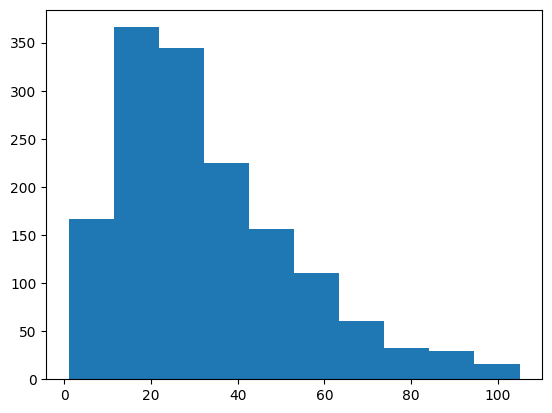

In [65]:
import matplotlib.pyplot as plt

l = list(map(len, words_vectors))
plt.hist(l)

In [69]:
import torch

class extract_tensor(torch.nn.Module):
    def forward(self,x):
        tensor, _ = x
        return tensor[:, -1, :] 

class MyBeautifulModel(torch.nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size):
        super(MyBeautifulModel, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Embedding(vocab_size, hidden_size),
            torch.nn.Dropout(0.2),
            torch.nn.LSTM(hidden_size, hidden_size),
            extract_tensor(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, X):
        return self.model(X)

In [70]:
from sklearn.metrics import f1_score
from torch import optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

EPOCHS = 600 

def train(model, x, y) -> nn.Module:
    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adagrad(model.parameters(), lr=0.001)

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)
    train_x = torch.Tensor(train_x).to(torch.int64)
    test_x = torch.Tensor(test_x).to(torch.int64)
    train_y = torch.Tensor(train_y).to(torch.int64)
    test_y = torch.Tensor(test_y).to(torch.int64)
    
    train_loss = []
    test_loss = []
    model.train()
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = criterion(outputs, train_y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')
        with torch.no_grad():
            model.eval()
            outputs = model(test_x)
            loss = criterion(outputs, test_y)
            test_loss.append(loss.item())
            model.train()
            
    with torch.no_grad():
        model.eval()
        train_pred = torch.argmax(model(train_x), dim=1).numpy()
        test_pred = torch.argmax(model(test_x), dim=1).numpy()

    print(f"f1 on train: {f1_score(train_y, train_pred)}, f1 on test: {f1_score(test_y, test_pred)}")
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    return model


1507
Epoch [1/600], Loss: 0.7326
Epoch [2/600], Loss: 0.7297
Epoch [3/600], Loss: 0.7276
Epoch [4/600], Loss: 0.7259
Epoch [5/600], Loss: 0.7245
Epoch [6/600], Loss: 0.7234
Epoch [7/600], Loss: 0.7224
Epoch [8/600], Loss: 0.7212
Epoch [9/600], Loss: 0.7202
Epoch [10/600], Loss: 0.7197
Epoch [11/600], Loss: 0.7187
Epoch [12/600], Loss: 0.7180
Epoch [13/600], Loss: 0.7172
Epoch [14/600], Loss: 0.7165
Epoch [15/600], Loss: 0.7160
Epoch [16/600], Loss: 0.7155
Epoch [17/600], Loss: 0.7146
Epoch [18/600], Loss: 0.7142
Epoch [19/600], Loss: 0.7141
Epoch [20/600], Loss: 0.7132
Epoch [21/600], Loss: 0.7126
Epoch [22/600], Loss: 0.7123
Epoch [23/600], Loss: 0.7117
Epoch [24/600], Loss: 0.7113
Epoch [25/600], Loss: 0.7110
Epoch [26/600], Loss: 0.7103
Epoch [27/600], Loss: 0.7099
Epoch [28/600], Loss: 0.7094
Epoch [29/600], Loss: 0.7092
Epoch [30/600], Loss: 0.7087
Epoch [31/600], Loss: 0.7084
Epoch [32/600], Loss: 0.7080
Epoch [33/600], Loss: 0.7078
Epoch [34/600], Loss: 0.7075
Epoch [35/600], Lo

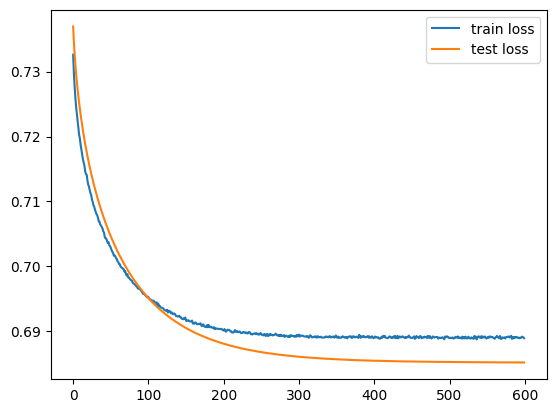

In [71]:
model = MyBeautifulModel(hidden_size=15, output_size=2, vocab_size=len(vocab))
print(len(words_embeddings))

y = pd.get_dummies(df.type).astype(int).values
model = train(model, words_embeddings, df.type.values)
# y